In [2]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import glob
import os
import pickle
import sys


In [3]:
def stampaImmagine(image):
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    
def getRectangleMask(larghezza, altezza, nQuadrante = -1,percentualeImmagine = 30):
    step_terzi_h = int(np.floor(altezza/3))
    
    CENTRO_ALTO_H = step_terzi_h
    CENTRO_BASSO_H = step_terzi_h * 2
    
    step_terzi_w = int(np.floor(larghezza/3))
    delta = int(( larghezza * np.floor(percentualeImmagine/2) ) / 100 )
    
    CENTRO_IMG = int (np.floor(larghezza/2))
    LIM_SX = CENTRO_IMG - delta
    LIM_DX = CENTRO_IMG + delta
    
    if LIM_SX < 0:
        LIM_SX = 0
    if LIM_DX >= larghezza:
        LIM_DX = larghezza-1
    mask = np.zeros((altezza,larghezza), np.uint8)
    mask = np.array(mask)
    
    if nQuadrante == 0:
        mask[0:CENTRO_ALTO_H, LIM_SX:LIM_DX] = 1
        return mask
    elif nQuadrante == 1:
        mask[CENTRO_ALTO_H:CENTRO_BASSO_H, LIM_SX:LIM_DX] = 1
        return mask
    elif nQuadrante == 2:
        mask[CENTRO_BASSO_H:altezza, LIM_SX:LIM_DX] = 1
        return mask
        
    mask[0:altezza, LIM_SX:LIM_DX] = 1
    return mask

In [4]:
# prende in input due path, dal percorso in Input legge il video,  
# prende per ogni secondo il frame centrale e lo salva in formato .jpg nel percorso in output
# restituisce solo False se ci sono stati errori o True

# (path video, nome file firma, numero di frame al secondo, flag/(False)carica file firma o (True)genera firma)
def getRenctangleSignature(pathInput, fileName, nFrame, flag, mode = 0, percentualeImmagine = 30): 
    
#     try:
#         filelist = glob.glob(pathOutput+"\*.jpg")
#         for fls in filelist:
#             os.remove(fls)
#     except Exception as e:
#         print(e)
    immagini = []    
    cap = cv2.VideoCapture(pathInput)
    print "Larghezza: ",cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    print "Altezza: ", cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    print "Frame Rate: ",np.floor(cap.get(cv2.CAP_PROP_FPS))
    print "Numero Totale di frame: ", cap.get(cv2.CAP_PROP_FRAME_COUNT)
    larghezza = (int)(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    altezza = (int)(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    #set limiti mask
    frameRate = np.floor(cap.get(cv2.CAP_PROP_FPS))
    
    if nFrame > frameRate:
        print "numero frame > framerate "
        
    
    if mode == 0:
        detector = cv2.xfeatures2d.SIFT_create()
        fileName = "sift_"+fileName 
    if mode == 1 :
        fileName = "surf_"+fileName 
        detector = cv2.xfeatures2d.SURF_create(50,5,5,1)
    i=0
    print detector
    all_descriptor = []
    stampaImmagine(getRectangleMask(larghezza, altezza, -1, percentualeImmagine) )
    statusMask  = False # mask generata ? 
    
    if flag:
        while(cap.isOpened()):
            frameId = cap.get(cv2.CAP_PROP_POS_FRAMES) #frame attuale
            modulo = frameId % np.ceil(frameRate/nFrame)  #  0 - frameRate-1
            ret, frame = cap.read()
            if statusMask == False:
                larghezza = len(frame[0])
                altezza = len(frame)
                mask_0 = getRectangleMask(larghezza, altezza, 0, percentualeImmagine) 
                mask_1 = getRectangleMask(larghezza, altezza, 1, percentualeImmagine) 
                mask_2 = getRectangleMask(larghezza, altezza, 2, percentualeImmagine) 
                statusMask = True
            if (ret != True):
                break
            if(modulo == 0 and ret == True): #salviamo il frame centrale
                _, des_0 = detector.detectAndCompute(frame,mask_0)
                _, des_1 = detector.detectAndCompute(frame,mask_1)
                _, des_2 = detector.detectAndCompute(frame,mask_2)
                if des_0 is not None or des_1 is not None or des_2 is not None:
                    tmp_sign_frame = []
                    tmp_sign_frame.append(des_0)
                    tmp_sign_frame.append(des_1)
                    tmp_sign_frame.append(des_2)
                    all_descriptor.append(tmp_sign_frame)
        cap.release()
        with open (fileName, "wb") as f:
            pickle.dump(all_descriptor, f, pickle.HIGHEST_PROTOCOL)
        return all_descriptor
    else : 
        with open(fileName, "rb") as f:
            dump = pickle.load(f)
        return dump        

In [5]:
def filterLowe2(matches,threshold=0.8):
    out_matches=[]
    for m1,m2 in matches:
        if m1[0]/m2[0]<threshold:
            out_matches.append(m1[0])
    return out_matches

In [6]:
def manualMatching(des1, des2):
    if des1 is None:
        return -1
    if des2 is None:
        return -1
    matches = []
    for i in range (0, len (des1)):
        min1 = 3000.0
        min2 = 3000.0
        for j in range (0, len(des2)):
            dist = (np.sqrt(sum((des1[i] - des2[j])**2)))
            if dist < min1:
                min2 = min1
                min1 = dist
        matches.append([[min1, 0, 0],[min2, 0, 0]])
    return matches

In [7]:
def checkMatchRectangle(outMatch, soglia,n_match, somma_check): #n_match numero di match(sift) minimi sotto la soglia
    count = somma_check
    if outMatch is None:
        return count 
    for o in outMatch:
        if o <= soglia:
            count = count +1
            if count >= n_match:
                return count
    return count

def sumLenght(frame):
    somma = 0
    for f in frame:
        if f is not None:
            somma = len(f)+ somma
    return somma

def votingFrame(s1, s2):
    v = [1.0,1.0,1.0,1.0]
    for i in range(0,3):
        if s1[i] is not None and s2[i] is not None:
            v[i] = abs( 1 - (float(len(s1[i]))/float(len(s2[i]))))
    len_s1 = sumLenght(s1)
    len_s2 = sumLenght(s2)
    v[3] = abs( 1 - (float(len_s1/float(len_s2))))
    c = 0
   
    for x in v:
        if (0.4) > x:
            c = c+1
    
    if c > 1:
#         print "Not Skip : voting : ", v, " - len_s1 : ", len_s1, " - len_s2 : ", len_s2, " - c < 0.4:", c
        return True
#     print "Skip : voting : ", v, " - len_s1 : ", len_s1, " - len_s2 : ", len_s2, " - c < 0.4:", c
    return False

def frameMatching(f1, f2, soglia, n_match):
    check_num_match = 0
    log = np.array([])
    for i in range(0,3):
        outMatch = manualMatching(f1[i], f2[i])
        if outMatch != -1 :
            outMatch = filterLowe2(outMatch)
            check_num_match = checkMatchRectangle(outMatch, soglia,n_match, check_num_match)
    
            if outMatch is not None :
                log = np.append(log, outMatch)
        if check_num_match >= n_match:
            log = np.sort(log)
            log = log[0:n_match]
            return True, log
    log = np.sort(log)
    if len(log) > n_match:
        log = log[0:n_match]
    return False, log

def compareLog(log1, log2):

    if len(log1) == 0:
        return log2
    if len(log1) > 0 and len(log2)>0:
        if np.mean(log1)< np.mean(log2):
            return log1
        return log2
    if len(log2) == 0:
        return log1
    
    
def matchSignatureRectangle(sign1, sign2, soglia, n_match,pathname, verbose=False): #metodo da richiamare
    matches = []
    indexFrame = 0
    i = 0
    count = 0
    pathname = str(pathname+".txt")
    if(verbose==True):
        fls = open(pathname,"w")
    for s1 in sign1:
        
        print "-------------------FRAME ", indexFrame,"---------------------"
        if(verbose==True):
            fls.write("-------------------FRAME "+str(indexFrame)+"---------------------\n")
        match = False
        len_s1 = sumLenght(s1)
        log = np.array([])
        if len_s1 >= n_match:
            while i < len(sign2) and match== False:
                if count == 5:
                    i = 0
#                     print "-----------------------------------------"
#                     print "reset i :  - frame :", indexFrame, " - count :", count
#                     print "-----------------------------------------"
                len_s2 = sumLenght(sign2[i])
                if len_s2 >= n_match:
                    if votingFrame(s1, sign2[i]) : 
                        #print "not skip : ", len_s2
                        status, tmp_log = frameMatching(s1, sign2[i], soglia, n_match)
                        if tmp_log is not None:
                            log = compareLog(log, tmp_log)
                        if status :
                            matches.append(1)
                            match = True
                        else : 
                            i = i+1
                            count = count +1
                           # print "---- count A ", count
                    else :
                        #print "skip : ", len_s2, " - i :", i, "  - count : ", count
                        i = i+1
                        count = count +1
                      #  print "---- count C ", count
                else :
                    i = i+1
                    count = count +1
                    #print "---- count D ", count
            
            count = 0
            if match == False:
                matches.append(0)
            print "Frame originale in analisi:",indexFrame, "  - Match : ", matches[indexFrame], " frameAnlisi : ",i
            if(verbose==True):
                fls.write(str("Frame originale in analisi:"+ str(indexFrame)+ "  - Match : "+ str(matches[indexFrame])+" frameAnlisi : "+str(i)+"\n"))
            indexFrame = indexFrame+1
            if match == False:
                i = 0
        else :
            if(verbose==True):
                for l in log: 
                    fls.write(str(l))
                    fls.write(" - ")
                fls.write("\n")
            print log
            if match == False:
                matches.append(-1)
            if(verbose==True):
                fls.write(str("Frame originale in analisi:"+ str(indexFrame)+ " -  Skip(Numero sift non sufficiente per il Match)"))
            print "Frame originale in analisi:", indexFrame, " -  Skip(Numero sift non sufficiente per il Match)"
            indexFrame = indexFrame+1
        if(verbose==True):
            for l in log: 
                fls.write(str(l))
                fls.write(" - ")
            fls.write("\n")
            fls.write("-----------------------------------------------\n")
        print log
        print "-----------------------------------------------"
        
    if(verbose==True):
        fls.close()
    return matches
   

# MAIN

In [8]:
#TASK
#PRE-PROCESSING video originale
# Parametrizzare il n° di frame al secondo da estrarre dal video 
# (creare un unico metodo per riutilizzarlo co il video da analizzare)
# per ogni frame stabilire una mask (il video originale potrebbe non avere una maschera ma calcolare la firma su tutto il frame)
# sulla porzione di frame (o sull'intero) definita dalla mask calcolare SIFT e SURF (definire un metodo per ALL sift oppure un limite massimo N_MAX)
#organizzare le SIFT e le SURF in modo da stabilire una firma ( SIFT troppo simili potrebbero essere eliminate tra frame dello stesso video)

#FASE DI ANALISI
# stabilire una sogliatura per la distanza tra SIFT (SE UN GRUPPO (parametrizzato) DI SIFT SONO INFERIORI AD UNA CERTA DISTANZA) allora match
# analisi: se almeno il X % dei frame analizzati MATCHA il risultato sarà una violazione del copyright
# indicare gli indici dei frame che hanno match tra il video originale e il video da analizzare
# organizzare il risultato come una percentuale di frame che matchano come output

# Creazione firma

Larghezza:  854.0
Altezza:  480.0
Frame Rate:  29.0
Numero Totale di frame:  3686.0
<xfeatures2d_SIFT 000000001083AF70>


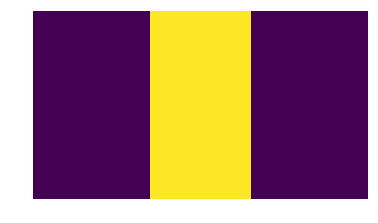

In [37]:
# (path video, nome file firma, numero di frame al secondo, SIFT = 0 / SURF = 1,flag/(False)carica file firma o (True)genera firma)
#signature_originale = getSignature("VideoOriginale\GotTrailerOriginal.mp4","firma_originale_Got", 1, False)

# (path video, nome file firma, numero di frame al secondo, flag/(False)carica file firma o (True)genera firma)
path = "VideoOriginale\GotTrailerBassaRisoluzione.mp4"
file_Name = "BassaRisoluzione"
signature_originale = getRenctangleSignature(path, file_Name, 1, True, 0)

In [38]:
print len(signature_originale)

105


# Analisi Video

In [9]:

def getSignatureFile(videoAnalisi, selezioneFirma):
    path_originale  = ["VideoOriginale\GotTrailerOriginal.mp4", "originale_Got"]
    path_analisi = [["VideoOriginale\GotTrailerSpecchiato.mp4", "specchiato_got"],
                    ["VideoOriginale\GotTrailerLuminoso.mp4", "luminoso_got"],
                    ["VideoOriginale\Originale.mp4", "NottedaLeoni"],
                   ["VideoOriginale\GotTrailerRiconvertito.mp4", "Riconvertito"],
                   ["VideoOriginale\GotTrailerBassaRisoluzione.mp4", "BassaRisoluzione"]] 
    p_analisi = path_analisi[videoAnalisi][0]
    p_file_analisi = path_analisi[videoAnalisi][1]
    
    print p_analisi
    print p_file_analisi
    
    sift_originale = 0
    surf_originale = 0
    sift_analisi = 0
    surf_analisi = 0
    if selezioneFirma == 0:
        sift_originale = getRenctangleSignature(path_originale[0], path_originale[1], 1, False, 0)
        sift_analisi = getRenctangleSignature(path_analisi[videoAnalisi][0], path_analisi[videoAnalisi][1], 1, False, 0)
        return sift_originale, sift_analisi
    elif selezioneFirma == 1:
        surf_originale = getRenctangleSignature(path_originale[0], path_originale[1], 1, False, 1)
        surf_analisi = getRenctangleSignature(path_analisi[videoAnalisi][0], path_analisi[videoAnalisi][1], 1, False, 1)
        return surf_originale, surf_analisi
    else :
        sift_originale = getRenctangleSignature(path_originale[0], path_originale[1], 1, False, 0)
        sift_analisi = getRenctangleSignature(path_analisi[videoAnalisi][0], path_analisi[videoAnalisi][1], 1, False, 0)
        surf_originale = getRenctangleSignature(path_originale[0], path_originale[1], 1, False, 1)
        surf_analisi = getRenctangleSignature(path_analisi[videoAnalisi][0], path_analisi[videoAnalisi][1], 1, False, 1)
        return sift_originale, sift_analisi, surf_originale, surf_analisi
    
    return -1

    

VideoOriginale\GotTrailerBassaRisoluzione.mp4
BassaRisoluzione
Larghezza:  1280.0
Altezza:  720.0
Frame Rate:  23.0
Numero Totale di frame:  2948.0
<xfeatures2d_SIFT 0000000008BC7830>


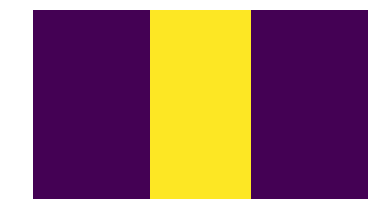

Larghezza:  854.0
Altezza:  480.0
Frame Rate:  29.0
Numero Totale di frame:  3686.0
<xfeatures2d_SIFT 0000000012148AD0>


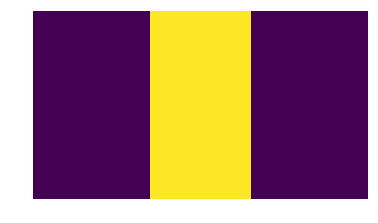

Larghezza:  1280.0
Altezza:  720.0
Frame Rate:  23.0
Numero Totale di frame:  2948.0
<xfeatures2d_SURF 000000001291E1F0>


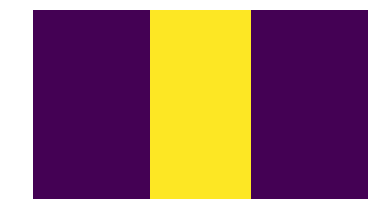

Larghezza:  854.0
Altezza:  480.0
Frame Rate:  29.0
Numero Totale di frame:  3686.0
<xfeatures2d_SURF 0000000013F73970>


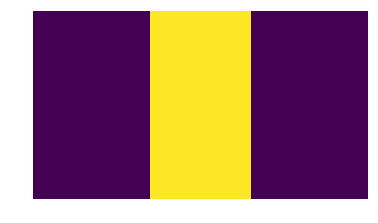

In [17]:
#0 specchiato, 1 luminoso
sift_originale, sift_analisi, surf_originale, surf_analisi = getSignatureFile(4, 2)

In [18]:
print len(sift_analisi), len(sift_originale)

105 112


In [19]:
#Match SIFT 200 - 10

match_sift = matchSignatureRectangle(sift_originale, sift_analisi,100, 10, "distanze_SIFT_BassaRisoluzione", verbose=False)

-------------------FRAME  0 ---------------------
Frame originale in analisi: 0   - Match :  0  frameAnlisi :  105
[ 174.24982066  175.20844728  185.82249595  190.74852555  199.5570094
  202.23995649  203.15757431  203.41337223  204.84872467  206.27893736]
-----------------------------------------------
-------------------FRAME  1 ---------------------
Frame originale in analisi: 1   - Match :  0  frameAnlisi :  105
[ 174.14936118  175.20844728  187.88294228  190.74852555  200.42704408
  202.20039565  203.15757431  203.55097642  203.60500976  206.27893736]
-----------------------------------------------
-------------------FRAME  2 ---------------------
[]
Frame originale in analisi: 2  -  Skip(Numero sift non sufficiente per il Match)
[]
-----------------------------------------------
-------------------FRAME  3 ---------------------
[]
Frame originale in analisi: 3  -  Skip(Numero sift non sufficiente per il Match)
[]
-----------------------------------------------
-------------------

Frame originale in analisi: 32   - Match :  0  frameAnlisi :  105
[ 100.39422294  101.20770722  107.1027544   120.12077256  122.18837915
  131.22118731  138.05071532  164.48404178  176.88696956  180.13328399]
-----------------------------------------------
-------------------FRAME  33 ---------------------
Frame originale in analisi: 33   - Match :  0  frameAnlisi :  105
[  91.10982384   91.40021882   97.6012295   105.87256491  107.0046728
  108.32820501  108.4020295   109.68135667  114.75626345  124.95199078]
-----------------------------------------------
-------------------FRAME  34 ---------------------
Frame originale in analisi: 34   - Match :  0  frameAnlisi :  105
[  58.61740356   74.49161027   77.83957862   78.68926229   84.85281374
   90.23303165  102.67424214  103.75451797  104.95237015  113.85077953]
-----------------------------------------------
-------------------FRAME  35 ---------------------
Frame originale in analisi: 35   - Match :  0  frameAnlisi :  105
[ 103.04368

Frame originale in analisi: 61   - Match :  0  frameAnlisi :  105
[ 111.88386836  132.22707741  148.81532179  169.18333251  176.33774412
  189.29870575  194.14427625  211.896201    254.9568591   281.79247683]
-----------------------------------------------
-------------------FRAME  62 ---------------------
Frame originale in analisi: 62   - Match :  0  frameAnlisi :  105
[ 204.93901532  245.75190742  248.22368944  251.34438526  257.04863353
  287.95138479  303.01485112  319.31175988  334.59378356  359.9291597 ]
-----------------------------------------------
-------------------FRAME  63 ---------------------
Frame originale in analisi: 63   - Match :  0  frameAnlisi :  105
[ 180.37461019  199.24356953  236.39796953  245.35892077  252.90709757
  263.1900454   265.84205837  276.73272304  278.49775583  279.86603938]
-----------------------------------------------
-------------------FRAME  64 ---------------------
Frame originale in analisi: 64   - Match :  0  frameAnlisi :  105
[]
-------

Frame originale in analisi: 95   - Match :  1  frameAnlisi :  85
[ 31.95309062  36.26292873  40.21193853  47.68647607  48.17675788
  48.70318265  50.88221693  51.56549234  52.5832673   55.14526272]
-----------------------------------------------
-------------------FRAME  96 ---------------------
Frame originale in analisi: 96   - Match :  1  frameAnlisi :  90
[ 49.61854492  50.87238937  61.03277808  62.32976817  63.70243323
  64.86909896  67.72001181  67.99264666  71.05631569  71.19691005]
-----------------------------------------------
-------------------FRAME  97 ---------------------
Frame originale in analisi: 97   - Match :  0  frameAnlisi :  105
[  57.13142743   66.58828726   73.74279626   96.10411021  102.2252415
  106.91585476  116.50321884  117.13667231  117.50744657  118.84443613]
-----------------------------------------------
-------------------FRAME  98 ---------------------
Frame originale in analisi: 98   - Match :  0  frameAnlisi :  105
[  65.48282217   73.4982993    77

In [20]:
print match_sift

[0, 0, -1, -1, -1, -1, -1, 0, -1, -1, 1, -1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 1, 0, -1, 0, 0, -1, 0, 1, 1, 0, 0, -1, 0, -1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [21]:
# MATCH SURF 0.1 - 10
match_surf = matchSignatureRectangle(surf_originale, surf_analisi,0.1, 10, "distanze_SURF_BassaRisoluzione", verbose=False)

-------------------FRAME  0 ---------------------
Frame originale in analisi: 0   - Match :  0  frameAnlisi :  119
[ 0.1537112   0.156523    0.1576772   0.16614621  0.17122514  0.17699607
  0.18111158  0.18671924  0.20219774  0.20871162]
-----------------------------------------------
-------------------FRAME  1 ---------------------
Frame originale in analisi: 1   - Match :  0  frameAnlisi :  119
[ 0.15369498  0.15647038  0.15766647  0.16614619  0.17226927  0.18111156
  0.18186026  0.1867218   0.20247329  0.22803494]
-----------------------------------------------
-------------------FRAME  2 ---------------------
Frame originale in analisi: 2   - Match :  0  frameAnlisi :  119
[ 0.21191864  0.21457039  0.2279953   0.23059534  0.26106927  0.27096642
  0.27718344  0.27962381  0.28722704  0.30655467]
-----------------------------------------------
-------------------FRAME  3 ---------------------
Frame originale in analisi: 3   - Match :  0  frameAnlisi :  119
[ 0.08431323  0.10253184  0

Frame originale in analisi: 30   - Match :  0  frameAnlisi :  119
[ 0.13409778  0.14306536  0.18066239  0.19585708  0.20284127  0.20969427
  0.21374137  0.21783643  0.22072034  0.23212997]
-----------------------------------------------
-------------------FRAME  31 ---------------------
Frame originale in analisi: 31   - Match :  0  frameAnlisi :  119
[ 0.18930775  0.20228302  0.2459032   0.28346589  0.29400839  0.31143357
  0.31315421  0.33163696  0.33855467  0.37830281]
-----------------------------------------------
-------------------FRAME  32 ---------------------
Frame originale in analisi: 32   - Match :  0  frameAnlisi :  119
[ 0.05720461  0.0618181   0.06411803  0.07972064  0.08768871  0.09332031
  0.09361933  0.09628542  0.09885284  0.1037318 ]
-----------------------------------------------
-------------------FRAME  33 ---------------------
Frame originale in analisi: 33   - Match :  0  frameAnlisi :  119
[]
-----------------------------------------------
-------------------

Frame originale in analisi: 59   - Match :  0  frameAnlisi :  119
[ 0.19726748  0.22047306  0.22683262  0.23331974  0.23480087  0.25039001
  0.26375415  0.27279105  0.28166966  0.28505517]
-----------------------------------------------
-------------------FRAME  60 ---------------------
Frame originale in analisi: 60   - Match :  0  frameAnlisi :  119
[ 0.15889099  0.17161144  0.21882072  0.22063163  0.23149187  0.23850547
  0.23980803  0.27669115  0.28355135  0.29928895]
-----------------------------------------------
-------------------FRAME  61 ---------------------
Frame originale in analisi: 61   - Match :  0  frameAnlisi :  119
[ 0.27606199  0.27876642  0.28191246  0.28310263  0.29474038  0.31804002
  0.3181032   0.3189123   0.32420032  0.36175741]
-----------------------------------------------
-------------------FRAME  62 ---------------------
Frame originale in analisi: 62   - Match :  0  frameAnlisi :  119
[ 0.17401903  0.18358742  0.18801973  0.19234331  0.19512696  0.195525

Frame originale in analisi: 89   - Match :  0  frameAnlisi :  119
[ 0.20781569  0.2330568   0.26770959  0.31245393  0.31416731  0.31981066
  0.33467066  0.33621446  0.3534486   0.35359454]
-----------------------------------------------
-------------------FRAME  90 ---------------------
Frame originale in analisi: 90   - Match :  0  frameAnlisi :  119
[ 0.23750844  0.23867245  0.24051657  0.32229155  0.32865036  0.33508158
  0.34634089  0.35812293  0.37396736  0.38334129]
-----------------------------------------------
-------------------FRAME  91 ---------------------
Frame originale in analisi: 91   - Match :  0  frameAnlisi :  119
[ 0.26488571  0.28301805  0.2840625   0.29535465  0.31910046  0.34595991
  0.36261316  0.38924314  0.39348278  0.39816741]
-----------------------------------------------
-------------------FRAME  92 ---------------------
Frame originale in analisi: 92   - Match :  0  frameAnlisi :  119
[ 0.22333638  0.22415189  0.26503888  0.31002309  0.32261096  0.337402

In [22]:
print match_surf

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0]


In [23]:
def countMatch(array):
    match=0
    no=0
    under=0
    for i in range (0,len(array)):
        if(array[i]==1):
            match+=1
        elif(array[i]==0):
            no+=1
        elif(array[i]==-1):
            under+=1
        else:
            print "valore non riconosciuto"
    
    
    return match, no, under
def plotResult(SIFT, SURF, filename, soglia_SIFT, soglia_SURF, n_SIFT, n_SURF, stampa=False):
    
    
    sift_match, sift_no, sift_under= countMatch(SIFT)
    surf_match, surf_no, surf_under= countMatch(SURF)
    
    title_SIFT ="SIFT - soglia: "+  str(soglia_SIFT) +" numSPF: " + str(n_SIFT)
    title_SURF ="SURF - soglia: "+  str(soglia_SURF) +" numSPF: " + str(n_SURF)

    fig, ax = plt.subplots(3,2)

    bar_width = 0.05
    space= 0.01
    opacity = 1
    error_config = {'ecolor': '0.3'}
    
    #-------------------------------------BAR 1------------------------------------------------------#
    rects1 = ax[0][0].bar(0, sift_match, bar_width, alpha=opacity, color='b', label= "SIFT_Matches")
    rects2 = ax[0][0].bar(0+space+bar_width, sift_no, bar_width, alpha=opacity, color='C1', label= "SIFT_NO_Matches")
    rects3 = ax[0][0].bar(0+space+ bar_width+space+bar_width, sift_under, bar_width, alpha=opacity, color='g', label= "SIFT_UnderThreshold")
   
    ax[0][0].set_ylabel('Numero di Frame')
    ax[0][0].set_title(title_SIFT)
    ax[0][0].legend(["Match", "NoMatch", "UnderThreshold"])
    ax[0][0].set_xticks([0,0+space+bar_width,0+space*2+bar_width*2])
    ax[0][0].set_xticklabels((sift_match,sift_no, sift_under))
    
    #-------------------------------------BAR 2------------------------------------------------------#
    rects4 = ax[0][1].bar(1,surf_match, bar_width, alpha=opacity, color='b', label="SURF_Matches")
    rects5 = ax[0][1].bar(1+space+bar_width,surf_no, bar_width, alpha=opacity, color='C1', label="SURF_No_Matches")
    rects6 = ax[0][1].bar(1+space+ bar_width+ bar_width+space,surf_under, bar_width, alpha=opacity, color='g', label="SURF_UnderThreshold")

    ax[0][1].set_ylabel('Numero di frame')
    ax[0][1].set_title(title_SURF)
    ax[0][1].legend(["Match", "NoMatch", "UnderThreshold"])
    ax[0][1].set_xticks([1,1+space+bar_width,1+space*2+bar_width*2])
    ax[0][1].set_xticklabels((surf_match,surf_no, surf_under))
    


    
    #---------------------------------PIE -------------------------------#
    
    #labels = 'Match', 'No_match', 'Under'
    sizes = [sift_match, sift_no, sift_under]
    explode = (0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

    ax[1][0].set_title("SIFT")
    ax[1][0].pie(sizes, explode=explode, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax[1][0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.



    #labels2 = 'Match', 'No_match'
    sizes2 = [sift_match, sift_no]
    explode2 = (0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
    ax[2][0].set_title(title_SIFT)
    ax[2][0].pie(sizes2, explode=explode2, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax[2][0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


    #labels3 = 'Match', 'No_match', 'Under'
    sizes3 = [surf_match, surf_no, surf_under]
    explode3 = (0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
    ax[1][1].set_title("SURF")
    ax[1][1].pie(sizes3, explode=explode3, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax[1][1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


    #labels4 = 'Match', 'No_match'
    sizes4 = [surf_match, surf_no]
    explode4 = (0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
    ax[2][1].set_title(title_SURF)
    ax[2][1].pie(sizes4, explode=explode4, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax[2][1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    fig.set_size_inches((15,18))
    
    if(stampa):
        plt.savefig(filename)
    plt.show()

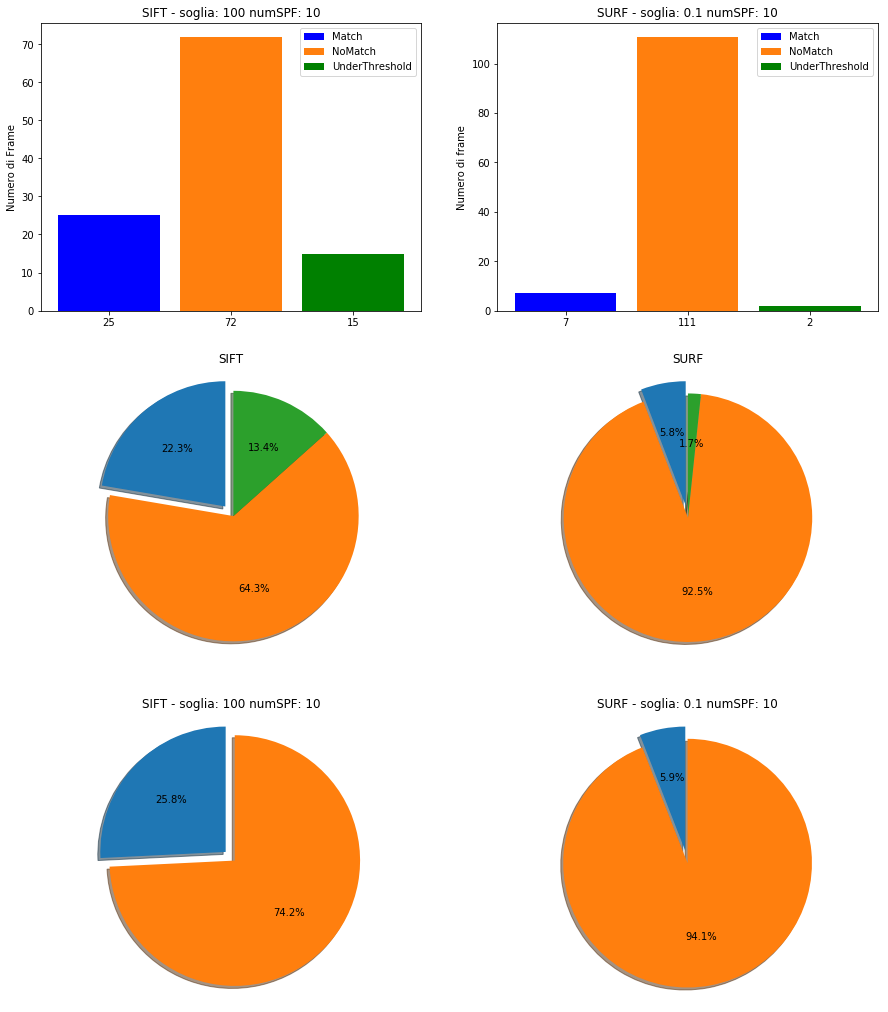

In [24]:
#(match_sift, match_surf, path_img_output, soglia sift, soglia surf, nsift_per_frame, nsurf_per_frame, save image)
plotResult(match_sift, match_surf,"OriginalevsBassaRisoluzione.png", 100,0.1,10,10, True)

In [74]:
def caricaImmagini(pathInput, nFrame):
    immagini = []
    cap = cv2.VideoCapture(pathInput)
    frameRate = np.floor(cap.get(cv2.CAP_PROP_FPS))
    while(cap.isOpened()):
        frameId = cap.get(cv2.CAP_PROP_POS_FRAMES) #frame attuale
        modulo = frameId % np.ceil(frameRate/nFrame)  #  0 - frameRate-1
        ret, frame = cap.read()
        if (ret != True):
            break
        if(modulo == 0 and ret == True): #salviamo il frame centrale
            immagini.append(frame)
    return immagini

In [251]:
img_originali = caricaImmagini("VideoOriginale\GotTrailerOriginal.mp4", 1)
img_analisi = caricaImmagini("VideoOriginale\GotTrailerLuminoso.mp4", 1)

In [252]:
print len(img_originali)
print len(img_analisi)

129
129


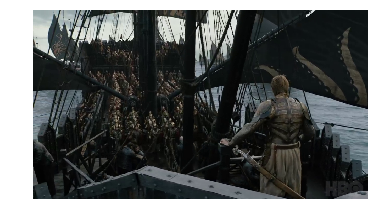

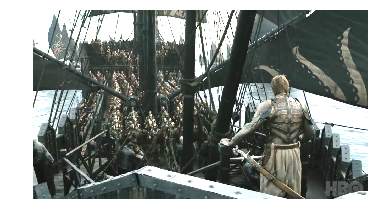

In [262]:
f = 30
img1 = img_originali[f][...,::-1]
img2 = img_analisi[f][...,::-1]
stampaImmagine(img1)
stampaImmagine(img2)
larghezza = len(img1[0])
altezza = len(img1)

In [254]:
# mask_0 = getRectangleMask(larghezza, altezza, 0) 
# mask_1 = getRectangleMask(larghezza, altezza, 1) 
# mask_2 = getRectangleMask(larghezza, altezza, 2) 
# stampaImmagine(mask_0)

In [267]:
video_1 = []
video_2 = []
img1 = img_originali[0][...,::-1]
img2 = img_analisi[0][...,::-1]
larghezza = len(img1[0])
altezza = len(img1)
mask_0 = getRectangleMask(larghezza, altezza, 0) 
mask_1 = getRectangleMask(larghezza, altezza, 1) 
mask_2 = getRectangleMask(larghezza, altezza, 2) 

surf = cv2.xfeatures2d.SURF_create(400,5,5,1)

for i in range(0, 60):
    
    img1 = img_originali[i][...,::-1]
    img2 = img_analisi[i][...,::-1]

    _, des_0 = surf.detectAndCompute(img1,mask_0)
    _, des_1 = surf.detectAndCompute(img1,mask_1)
    _, des_2 = surf.detectAndCompute(img1,mask_2)

    desc1 = []
    desc1.append(des_0)
    desc1.append(des_1)
    desc1.append(des_2)

#     larghezza = len(img2[0])
#     altezza = len(img2)
#     mask_0 = getRectangleMask(larghezza, altezza, 0) 
#     mask_1 = getRectangleMask(larghezza, altezza, 1) 
#     mask_2 = getRectangleMask(larghezza, altezza, 2) 
    _, des_0 = surf.detectAndCompute(img2,mask_0)
    _, des_1 = surf.detectAndCompute(img2,mask_1)
    _, des_2 = surf.detectAndCompute(img2,mask_2)

    desc2 = []
    desc2.append(des_0)
    desc2.append(des_1)
    desc2.append(des_2)
    
    video_1.append(desc1)
    video_2.append(desc2)
    print "iterazione : ",i 

iterazione :  0
iterazione :  1
iterazione :  2
iterazione :  3
iterazione :  4
iterazione :  5
iterazione :  6
iterazione :  7
iterazione :  8
iterazione :  9
iterazione :  10
iterazione :  11
iterazione :  12
iterazione :  13
iterazione :  14
iterazione :  15
iterazione :  16
iterazione :  17
iterazione :  18
iterazione :  19
iterazione :  20
iterazione :  21
iterazione :  22
iterazione :  23
iterazione :  24
iterazione :  25
iterazione :  26
iterazione :  27
iterazione :  28
iterazione :  29
iterazione :  30
iterazione :  31
iterazione :  32
iterazione :  33
iterazione :  34
iterazione :  35
iterazione :  36
iterazione :  37
iterazione :  38
iterazione :  39
iterazione :  40
iterazione :  41
iterazione :  42
iterazione :  43
iterazione :  44
iterazione :  45
iterazione :  46
iterazione :  47
iterazione :  48
iterazione :  49
iterazione :  50
iterazione :  51
iterazione :  52
iterazione :  53
iterazione :  54
iterazione :  55
iterazione :  56
iterazione :  57
iterazione :  58
iterazi

In [268]:

output = matchSignatureRectangle(video_1, video_2,0.1, 30)

-------------------FRAME  0 ---------------------
Not Skip : voting :  [0.0, 0.12324929971988796, 1.0, 0.12256267409470756]  - len_s1 :  315  - len_s2 :  359  - c < 0.4: 3
---------------------------
MATCH  : Count Numero Match :  30  - n_match 30
-----------------------------
Frame originale in analisi: 0   - Match :  1  frameAnlisi :  0
-----------------------------------------------
-------------------FRAME  1 ---------------------
Not Skip : voting :  [0.5, 0.12324929971988796, 1.0, 0.12534818941504178]  - len_s1 :  314  - len_s2 :  359  - c < 0.4: 2
---------------------------
MATCH  : Count Numero Match :  30  - n_match 30
-----------------------------
Frame originale in analisi: 1   - Match :  1  frameAnlisi :  0
-----------------------------------------------
-------------------FRAME  2 ---------------------
Frame originale in analisi: 2  -  Skip(Numero sift non sufficiente per il Match)
-----------------------------------------------
-------------------FRAME  3 ---------------

Not Skip : voting :  [0.17391304347826086, 0.5789473684210527, 1.0, 0.16176470588235303]  - len_s1 :  79  - len_s2 :  68  - c < 0.4: 2
---------------------------
NO MATCH  : Count Numero Match :  0  - n_match 30
-----------------------------
Skip : voting :  [1.375, 1.3076923076923075, 1.0, 0.9268292682926829]  - len_s1 :  79  - len_s2 :  41  - c < 0.4: 0
Skip : voting :  [0.3666666666666667, 0.45945945945945943, 1.0, 0.45890410958904104]  - len_s1 :  79  - len_s2 :  146  - c < 0.4: 1
Skip : voting :  [0.6545454545454545, 1.8571428571428572, 1.0, 0.03947368421052633]  - len_s1 :  79  - len_s2 :  76  - c < 0.4: 1
Skip : voting :  [0.2962962962962963, 0.42307692307692313, 1.0, 0.575268817204301]  - len_s1 :  79  - len_s2 :  186  - c < 0.4: 1
Not Skip : voting :  [0.05555555555555558, 0.34782608695652173, 1.0, 0.28181818181818186]  - len_s1 :  79  - len_s2 :  110  - c < 0.4: 3
---------------------------
NO MATCH  : Count Numero Match :  0  - n_match 30
-----------------------------
Skip

---------------------------
NO MATCH  : Count Numero Match :  0  - n_match 30
-----------------------------
Skip : voting :  [0.43333333333333335, 0.7837837837837838, 1.0, 0.7191780821917808]  - len_s1 :  41  - len_s2 :  146  - c < 0.4: 0
Skip : voting :  [0.6909090909090909, 0.1428571428571428, 1.0, 0.4605263157894737]  - len_s1 :  41  - len_s2 :  76  - c < 0.4: 1
Skip : voting :  [0.37037037037037035, 0.7692307692307692, 1.0, 0.7795698924731183]  - len_s1 :  41  - len_s2 :  186  - c < 0.4: 1
Skip : voting :  [0.05555555555555558, 0.7391304347826086, 1.0, 0.6272727272727272]  - len_s1 :  41  - len_s2 :  110  - c < 0.4: 1
Skip : voting :  [0.679245283018868, 0.6842105263157895, 1.0, 0.7028985507246377]  - len_s1 :  41  - len_s2 :  138  - c < 0.4: 0
Skip : voting :  [0.6851851851851851, 0.6571428571428571, 1.0, 0.7210884353741497]  - len_s1 :  41  - len_s2 :  147  - c < 0.4: 0
Skip : voting :  [1.0, 0.9083969465648855, 1.0, 0.8435114503816794]  - len_s1 :  41  - len_s2 :  262  - c < 0.4

Skip : voting :  [0.9721886336154776, 0.9642276422764228, 1.0, 0.975609756097561]  - len_s1 :  45  - len_s2 :  1845  - c < 0.4: 0
Skip : voting :  [0.9115384615384615, 0.941952506596306, 1.0, 0.957983193277311]  - len_s1 :  45  - len_s2 :  1071  - c < 0.4: 0
Not Skip : voting :  [1.0, 0.3125, 1.0, 0.2857142857142858]  - len_s1 :  45  - len_s2 :  35  - c < 0.4: 2
---------------------------
NO MATCH  : Count Numero Match :  0  - n_match 30
-----------------------------
Skip : voting :  [1.5555555555555554, 0.6764705882352942, 1.0, 0.5108695652173914]  - len_s1 :  45  - len_s2 :  92  - c < 0.4: 0
Skip : voting :  [4.75, 0.5217391304347826, 1.0, 0.09999999999999998]  - len_s1 :  45  - len_s2 :  50  - c < 0.4: 1
Skip : voting :  [0.21052631578947367, 0.8883248730964467, 1.0, 0.869942196531792]  - len_s1 :  45  - len_s2 :  346  - c < 0.4: 1
Frame originale in analisi: 23   - Match :  0  frameAnlisi :  60
-----------------------------------------------
-------------------FRAME  24 ----------

---------------------------
NO MATCH  : Count Numero Match :  0  - n_match 30
-----------------------------
Skip : voting :  [1.0, 10.19047619047619, 1.0, 5.911764705882353]  - len_s1 :  235  - len_s2 :  34  - c < 0.4: 0
Skip : voting :  [1.0, 5.714285714285714, 1.0, 3.196428571428571]  - len_s1 :  235  - len_s2 :  56  - c < 0.4: 0
Skip : voting :  [1.0, 5.527777777777778, 1.0, 3.2727272727272725]  - len_s1 :  235  - len_s2 :  55  - c < 0.4: 0
Not Skip : voting :  [1.0, 0.34173669467787116, 1.0, 0.34540389972144847]  - len_s1 :  235  - len_s2 :  359  - c < 0.4: 2
---------------------------
NO MATCH  : Count Numero Match :  0  - n_match 30
-----------------------------
Not Skip : voting :  [1.0, 0.35439560439560436, 1.0, 0.35967302452316074]  - len_s1 :  235  - len_s2 :  367  - c < 0.4: 2
---------------------------
NO MATCH  : Count Numero Match :  0  - n_match 30
-----------------------------
Skip : voting :  [1.0, 10.19047619047619, 1.0, 5.911764705882353]  - len_s1 :  235  - len_s2

---------------------------
NO MATCH  : Count Numero Match :  0  - n_match 30
-----------------------------
Skip : voting :  [0.16666666666666663, 4.631578947368421, 21.666666666666668, 2.447058823529412]  - len_s1 :  293  - len_s2 :  85  - c < 0.4: 1
Skip : voting :  [0.8518518518518519, 5.294117647058823, 135.0, 5.511111111111111]  - len_s1 :  293  - len_s2 :  45  - c < 0.4: 0
Not Skip : voting :  [0.020408163265306145, 0.17692307692307696, 7.5, 0.5025641025641026]  - len_s1 :  293  - len_s2 :  195  - c < 0.4: 2
---------------------------
NO MATCH  : Count Numero Match :  0  - n_match 30
-----------------------------
Skip : voting :  [0.33333333333333337, 0.833592534992224, 0.859358841778697, 0.826112759643917]  - len_s1 :  293  - len_s2 :  1685  - c < 0.4: 1
Skip : voting :  [2.8461538461538463, 0.8201680672268907, 0.8483835005574136, 0.8053156146179402]  - len_s1 :  293  - len_s2 :  1505  - c < 0.4: 0
Skip : voting :  [0.8680738786279684, 0.8296178343949044, 0.8181818181818181, 0.

---------------------------
NO MATCH  : Count Numero Match :  0  - n_match 30
-----------------------------
Skip : voting :  [0.3866666666666667, 0.8351477449455676, 0.8541882109617374, 0.826112759643917]  - len_s1 :  293  - len_s2 :  1685  - c < 0.4: 1
Skip : voting :  [2.5384615384615383, 0.8218487394957983, 0.842809364548495, 0.8053156146179402]  - len_s1 :  293  - len_s2 :  1505  - c < 0.4: 0
Skip : voting :  [0.8786279683377308, 0.8312101910828026, 0.8114973262032086, 0.833048433048433]  - len_s1 :  293  - len_s2 :  1755  - c < 0.4: 0
Skip : voting :  [0.8681948424068768, 0.8320126782884311, 0.8002832861189801, 0.8262158956109134]  - len_s1 :  293  - len_s2 :  1686  - c < 0.4: 0
Not Skip : voting :  [0.5576923076923077, 0.3416149068322981, 0.20512820512820507, 0.23298429319371727]  - len_s1 :  293  - len_s2 :  382  - c < 0.4: 3
---------------------------
NO MATCH  : Count Numero Match :  0  - n_match 30
-----------------------------
Skip : voting :  [0.7991266375545851, 0.6344827

---------------------------
NO MATCH  : Count Numero Match :  0  - n_match 30
-----------------------------
Skip : voting :  [2.2133333333333334, 0.8460342146189735, 0.9803516028955532, 0.7869436201780415]  - len_s1 :  359  - len_s2 :  1685  - c < 0.4: 0
Skip : voting :  [17.53846153846154, 0.8336134453781513, 0.9788182831661093, 0.7614617940199335]  - len_s1 :  359  - len_s2 :  1505  - c < 0.4: 0
Skip : voting :  [0.3641160949868074, 0.8423566878980892, 0.9745989304812834, 0.7954415954415954]  - len_s1 :  359  - len_s2 :  1755  - c < 0.4: 1
Skip : voting :  [0.3094555873925502, 0.8431061806656102, 0.9730878186968839, 0.7870699881376038]  - len_s1 :  359  - len_s2 :  1686  - c < 0.4: 1
Not Skip : voting :  [1.3173076923076925, 0.3850931677018633, 0.8376068376068376, 0.060209424083769614]  - len_s1 :  359  - len_s2 :  382  - c < 0.4: 2
---------------------------
NO MATCH  : Count Numero Match :  0  - n_match 30
-----------------------------
Skip : voting :  [0.05240174672489073, 0.6586

---------------------------
NO MATCH  : Count Numero Match :  0  - n_match 30
-----------------------------
Skip : voting :  [0.34545454545454546, 2.3333333333333335, 1.0, 0.894736842105263]  - len_s1 :  144  - len_s2 :  76  - c < 0.4: 1
Not Skip : voting :  [1.740740740740741, 0.32692307692307687, 1.0, 0.22580645161290325]  - len_s1 :  144  - len_s2 :  186  - c < 0.4: 2
---------------------------
NO MATCH  : Count Numero Match :  0  - n_match 30
-----------------------------
Not Skip : voting :  [3.1111111111111107, 0.23913043478260865, 1.0, 0.3090909090909091]  - len_s1 :  144  - len_s2 :  110  - c < 0.4: 2
---------------------------
NO MATCH  : Count Numero Match :  0  - n_match 30
-----------------------------
Not Skip : voting :  [0.39622641509433953, 0.07894736842105265, 1.0, 0.04347826086956519]  - len_s1 :  144  - len_s2 :  138  - c < 0.4: 3
---------------------------
NO MATCH  : Count Numero Match :  0  - n_match 30
-----------------------------
Not Skip : voting :  [0.3703

---------------------------
NO MATCH  : Count Numero Match :  0  - n_match 30
-----------------------------
Not Skip : voting :  [3.0, 0.08695652173913049, 1.0, 0.15999999999999992]  - len_s1 :  58  - len_s2 :  50  - c < 0.4: 2
---------------------------
NO MATCH  : Count Numero Match :  0  - n_match 30
-----------------------------
Skip : voting :  [0.1578947368421053, 0.7868020304568528, 1.0, 0.8323699421965318]  - len_s1 :  58  - len_s2 :  346  - c < 0.4: 1
Frame originale in analisi: 36   - Match :  0  frameAnlisi :  60
-----------------------------------------------
-------------------FRAME  37 ---------------------
Skip : voting :  [42.5, 0.09243697478991597, 1.0, 1.2590529247910864]  - len_s1 :  811  - len_s2 :  359  - c < 0.4: 1
Skip : voting :  [42.5, 0.10989010989010994, 399.0, 1.2098092643051772]  - len_s1 :  811  - len_s2 :  367  - c < 0.4: 1
Skip : voting :  [8.666666666666666, 14.428571428571429, 99.0, 22.852941176470587]  - len_s1 :  811  - len_s2 :  34  - c < 0.4: 0
Sk

---------------------------
NO MATCH  : Count Numero Match :  0  - n_match 30
-----------------------------
Not Skip : voting :  [0.8870967741935484, 0.36764705882352944, 0.12349397590361444, 0.03037974683544309]  - len_s1 :  766  - len_s2 :  790  - c < 0.4: 3
---------------------------
NO MATCH  : Count Numero Match :  0  - n_match 30
-----------------------------
Skip : voting :  [0.9735849056603774, 0.5889502762430939, 0.3501742160278746, 0.6631486367634125]  - len_s1 :  766  - len_s2 :  2274  - c < 0.4: 1
Skip : voting :  [0.974390243902439, 0.6223350253807107, 0.30797773654916516, 0.6732081911262799]  - len_s1 :  766  - len_s2 :  2344  - c < 0.4: 1
Not Skip : voting :  [0.9616087751371115, 0.2525252525252526, 1.783582089552239, 0.21676891615541927]  - len_s1 :  766  - len_s2 :  978  - c < 0.4: 2
---------------------------
NO MATCH  : Count Numero Match :  0  - n_match 30
-----------------------------
Skip : voting :  [0.7586206896551724, 4.391304347826087, 1.0, 3.910256410256410

---------------------------
NO MATCH  : Count Numero Match :  0  - n_match 30
-----------------------------
Not Skip : voting :  [0.435483870967742, 0.625, 0.09638554216867468, 0.27721518987341764]  - len_s1 :  1009  - len_s2 :  790  - c < 0.4: 2
---------------------------
NO MATCH  : Count Numero Match :  0  - n_match 30
-----------------------------
Skip : voting :  [0.6641509433962265, 0.5116022099447514, 0.4773519163763066, 0.5562884784520669]  - len_s1 :  1009  - len_s2 :  2274  - c < 0.4: 0
Skip : voting :  [0.674390243902439, 0.551269035532995, 0.4434137291280148, 0.5695392491467577]  - len_s1 :  1009  - len_s2 :  2344  - c < 0.4: 0
Skip : voting :  [0.5118829981718465, 0.4882154882154883, 1.2388059701492535, 0.0316973415132924]  - len_s1 :  1009  - len_s2 :  978  - c < 0.4: 1
Skip : voting :  [2.0689655172413794, 5.405797101449275, 1.0, 5.467948717948718]  - len_s1 :  1009  - len_s2 :  156  - c < 0.4: 0
Skip : voting :  [2.2962962962962963, 2.0482758620689654, 1.0, 3.464601769

---------------------------
NO MATCH  : Count Numero Match :  0  - n_match 30
-----------------------------
Skip : voting :  [6.75, 0.04347826086956519, 1.0, 1.2000000000000002]  - len_s1 :  110  - len_s2 :  50  - c < 0.4: 1
Skip : voting :  [0.631578947368421, 0.7563451776649746, 0.7615384615384615, 0.6820809248554913]  - len_s1 :  110  - len_s2 :  346  - c < 0.4: 0
Frame originale in analisi: 41   - Match :  0  frameAnlisi :  60
-----------------------------------------------
-------------------FRAME  42 ---------------------
Skip : voting :  [56.0, 0.6918767507002801, 1.0, 0.0696378830083566]  - len_s1 :  384  - len_s2 :  359  - c < 0.4: 1
Skip : voting :  [56.0, 0.6978021978021978, 159.0, 0.04632152588555849]  - len_s1 :  384  - len_s2 :  367  - c < 0.4: 1
Skip : voting :  [11.666666666666666, 4.238095238095238, 39.0, 10.294117647058824]  - len_s1 :  384  - len_s2 :  34  - c < 0.4: 0
Skip : voting :  [7.76923076923077, 2.142857142857143, 19.0, 5.857142857142857]  - len_s1 :  384  -

---------------------------
NO MATCH  : Count Numero Match :  0  - n_match 30
-----------------------------
Skip : voting :  [0.55, 6.421052631578948, 21.166666666666668, 3.317647058823529]  - len_s1 :  367  - len_s2 :  85  - c < 0.4: 0
Skip : voting :  [2.4444444444444446, 7.294117647058824, 132.0, 7.155555555555555]  - len_s1 :  367  - len_s2 :  45  - c < 0.4: 0
Skip : voting :  [0.8979591836734695, 0.08461538461538454, 7.3125, 0.882051282051282]  - len_s1 :  367  - len_s2 :  195  - c < 0.4: 1
Skip : voting :  [0.24, 0.7807153965785381, 0.8624612202688728, 0.7821958456973294]  - len_s1 :  367  - len_s2 :  1685  - c < 0.4: 1
Skip : voting :  [6.153846153846154, 0.7630252100840336, 0.8517279821627648, 0.7561461794019934]  - len_s1 :  367  - len_s2 :  1505  - c < 0.4: 0
Skip : voting :  [0.7546174142480211, 0.7754777070063694, 0.822192513368984, 0.7908831908831909]  - len_s1 :  367  - len_s2 :  1755  - c < 0.4: 0
Skip : voting :  [0.7335243553008596, 0.7765451664025357, 0.81161473087818

---------------------------
NO MATCH  : Count Numero Match :  0  - n_match 30
-----------------------------
Skip : voting :  [0.6550218340611353, 0.7379310344827585, 0.14111922141119226, 0.45376344086021503]  - len_s1 :  508  - len_s2 :  930  - c < 0.4: 1
Skip : voting :  [0.5797872340425532, 0.7790697674418605, 0.08072916666666663, 0.4454148471615721]  - len_s1 :  508  - len_s2 :  916  - c < 0.4: 1
Not Skip : voting :  [0.10227272727272729, 0.39682539682539686, 0.33396226415094343, 0.31720430107526887]  - len_s1 :  508  - len_s2 :  744  - c < 0.4: 4
---------------------------
MATCH  : Count Numero Match :  30  - n_match 30
-----------------------------
Frame originale in analisi: 44   - Match :  1  frameAnlisi :  44
-----------------------------------------------
-------------------FRAME  45 ---------------------
Not Skip : voting :  [0.19318181818181823, 0.20634920634920628, 0.4509433962264151, 0.3091397849462365]  - len_s1 :  514  - len_s2 :  744  - c < 0.4: 3
---------------------

---------------------------
NO MATCH  : Count Numero Match :  12  - n_match 30
-----------------------------
Skip : voting :  [1.0, 1.0, 0.6571428571428571, 0.9428571428571428]  - len_s1 :  136  - len_s2 :  70  - c < 0.4: 0
Skip : voting :  [1.0, 1.0, 0.8378378378378378, 0.08108108108108103]  - len_s1 :  136  - len_s2 :  148  - c < 0.4: 1
Skip : voting :  [0.875, 0.27338129496402874, 0.9169550173010381, 0.7364341085271318]  - len_s1 :  136  - len_s2 :  516  - c < 0.4: 1
Skip : voting :  [1.0, 0.5429864253393666, 0.8681318681318682, 0.662531017369727]  - len_s1 :  136  - len_s2 :  403  - c < 0.4: 0
Skip : voting :  [0.9866989117291415, 0.8357723577235773, 0.9404466501240695, 0.9262872628726287]  - len_s1 :  136  - len_s2 :  1845  - c < 0.4: 0
Skip : voting :  [0.9576923076923077, 0.7335092348284961, 0.9444444444444444, 0.873015873015873]  - len_s1 :  136  - len_s2 :  1071  - c < 0.4: 0
Skip : voting :  [1.0, 2.15625, 7.0, 2.8857142857142857]  - len_s1 :  136  - len_s2 :  35  - c < 0.4: 

---------------------------
NO MATCH  : Count Numero Match :  2  - n_match 30
-----------------------------
Skip : voting :  [1.0, 1.0, 0.6124567474048443, 0.7829457364341086]  - len_s1 :  112  - len_s2 :  516  - c < 0.4: 0
Skip : voting :  [1.0, 1.0, 0.3846153846153846, 0.7220843672456576]  - len_s1 :  112  - len_s2 :  403  - c < 0.4: 1
Skip : voting :  [1.0, 1.0, 0.7220843672456576, 0.9392953929539295]  - len_s1 :  112  - len_s2 :  1845  - c < 0.4: 0
Skip : voting :  [1.0, 1.0, 0.7407407407407407, 0.8954248366013072]  - len_s1 :  112  - len_s2 :  1071  - c < 0.4: 0
Skip : voting :  [1.0, 1.0, 36.333333333333336, 2.2]  - len_s1 :  112  - len_s2 :  35  - c < 0.4: 0
Skip : voting :  [1.0, 1.0, 6.466666666666667, 0.21739130434782616]  - len_s1 :  112  - len_s2 :  92  - c < 0.4: 1
Skip : voting :  [1.0, 1.0, 1.0, 1.2400000000000002]  - len_s1 :  112  - len_s2 :  50  - c < 0.4: 0
Skip : voting :  [1.0, 1.0, 0.1384615384615384, 0.676300578034682]  - len_s1 :  112  - len_s2 :  346  - c < 0.4

---------------------------
NO MATCH  : Count Numero Match :  0  - n_match 30
-----------------------------
Skip : voting :  [1.0, 5.619047619047619, 1.0, 1.3552631578947367]  - len_s1 :  179  - len_s2 :  76  - c < 0.4: 0
Not Skip : voting :  [1.0, 0.33653846153846145, 0.2727272727272727, 0.037634408602150504]  - len_s1 :  179  - len_s2 :  186  - c < 0.4: 3
---------------------------
NO MATCH  : Count Numero Match :  0  - n_match 30
-----------------------------
Skip : voting :  [1.0, 0.5108695652173914, 1.0, 0.6272727272727272]  - len_s1 :  179  - len_s2 :  110  - c < 0.4: 0
Skip : voting :  [1.0, 0.8289473684210527, 3.4444444444444446, 0.2971014492753623]  - len_s1 :  179  - len_s2 :  138  - c < 0.4: 1
Skip : voting :  [1.0, 0.9857142857142858, 0.7391304347826086, 0.217687074829932]  - len_s1 :  179  - len_s2 :  147  - c < 0.4: 1
Skip : voting :  [1.0, 0.4694656488549618, 1.0, 0.316793893129771]  - len_s1 :  179  - len_s2 :  262  - c < 0.4: 1
Skip : voting :  [1.0, 0.653366583541147

---------------------------
NO MATCH  : Count Numero Match :  0  - n_match 30
-----------------------------
Not Skip : voting :  [2.1021505376344085, 0.34191176470588225, 0.3343373493975904, 0.4721518987341773]  - len_s1 :  1163  - len_s2 :  790  - c < 0.4: 2
---------------------------
NO MATCH  : Count Numero Match :  0  - n_match 30
-----------------------------
Skip : voting :  [0.27421383647798747, 0.5966850828729282, 0.6149825783972125, 0.4885664028144239]  - len_s1 :  1163  - len_s2 :  2274  - c < 0.4: 1
Skip : voting :  [0.2963414634146342, 0.6294416243654822, 0.5899814471243043, 0.503839590443686]  - len_s1 :  1163  - len_s2 :  2344  - c < 0.4: 1
Not Skip : voting :  [0.054844606946983454, 0.22895622895622902, 0.6492537313432836, 0.18916155419222913]  - len_s1 :  1163  - len_s2 :  978  - c < 0.4: 3
---------------------------
NO MATCH  : Count Numero Match :  0  - n_match 30
-----------------------------
Skip : voting :  [5.632183908045977, 4.2898550724637685, 1.0, 6.455128205

---------------------------
NO MATCH  : Count Numero Match :  0  - n_match 30
-----------------------------
Skip : voting :  [0.1333333333333333, 0.7807153965785381, 0.8490175801447777, 0.7910979228486646]  - len_s1 :  352  - len_s2 :  1685  - c < 0.4: 1
Skip : voting :  [4.0, 0.7630252100840336, 0.8372352285395763, 0.7661129568106313]  - len_s1 :  352  - len_s2 :  1505  - c < 0.4: 0
Skip : voting :  [0.8284960422163589, 0.7754777070063694, 0.8048128342245989, 0.7994301994301994]  - len_s1 :  352  - len_s2 :  1755  - c < 0.4: 0
Skip : voting :  [0.8137535816618912, 0.7765451664025357, 0.7932011331444759, 0.7912218268090154]  - len_s1 :  352  - len_s2 :  1686  - c < 0.4: 0
Not Skip : voting :  [0.375, 0.12422360248447206, 0.24786324786324787, 0.07853403141361259]  - len_s1 :  352  - len_s2 :  382  - c < 0.4: 4
---------------------------
NO MATCH  : Count Numero Match :  0  - n_match 30
-----------------------------
Skip : voting :  [0.7161572052401747, 0.5137931034482759, 0.64476885644

---------------------------
NO MATCH  : Count Numero Match :  0  - n_match 30
-----------------------------
Skip : voting :  [0.9333333333333333, 8.473684210526315, 9.833333333333334, 1.9294117647058822]  - len_s1 :  249  - len_s2 :  85  - c < 0.4: 0
Skip : voting :  [0.8518518518518519, 9.588235294117647, 64.0, 4.533333333333333]  - len_s1 :  249  - len_s2 :  45  - c < 0.4: 0
Not Skip : voting :  [0.9183673469387755, 0.3846153846153846, 3.0625, 0.2769230769230768]  - len_s1 :  249  - len_s2 :  195  - c < 0.4: 2
---------------------------
NO MATCH  : Count Numero Match :  0  - n_match 30
-----------------------------
Skip : voting :  [0.9466666666666667, 0.7200622083981337, 0.9327817993795243, 0.8522255192878339]  - len_s1 :  249  - len_s2 :  1685  - c < 0.4: 0
Skip : voting :  [0.6923076923076923, 0.6974789915966386, 0.927536231884058, 0.8345514950166113]  - len_s1 :  249  - len_s2 :  1505  - c < 0.4: 0
Skip : voting :  [0.9894459102902374, 0.713375796178344, 0.9131016042780749, 0.85

In [269]:
print output

[1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, 0, -1, -1, 0, 0, -1, 0, 0, 0, 0, 1, 1, 0, 0, 0, -1, -1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, -1, -1, -1, -1, -1, 0]


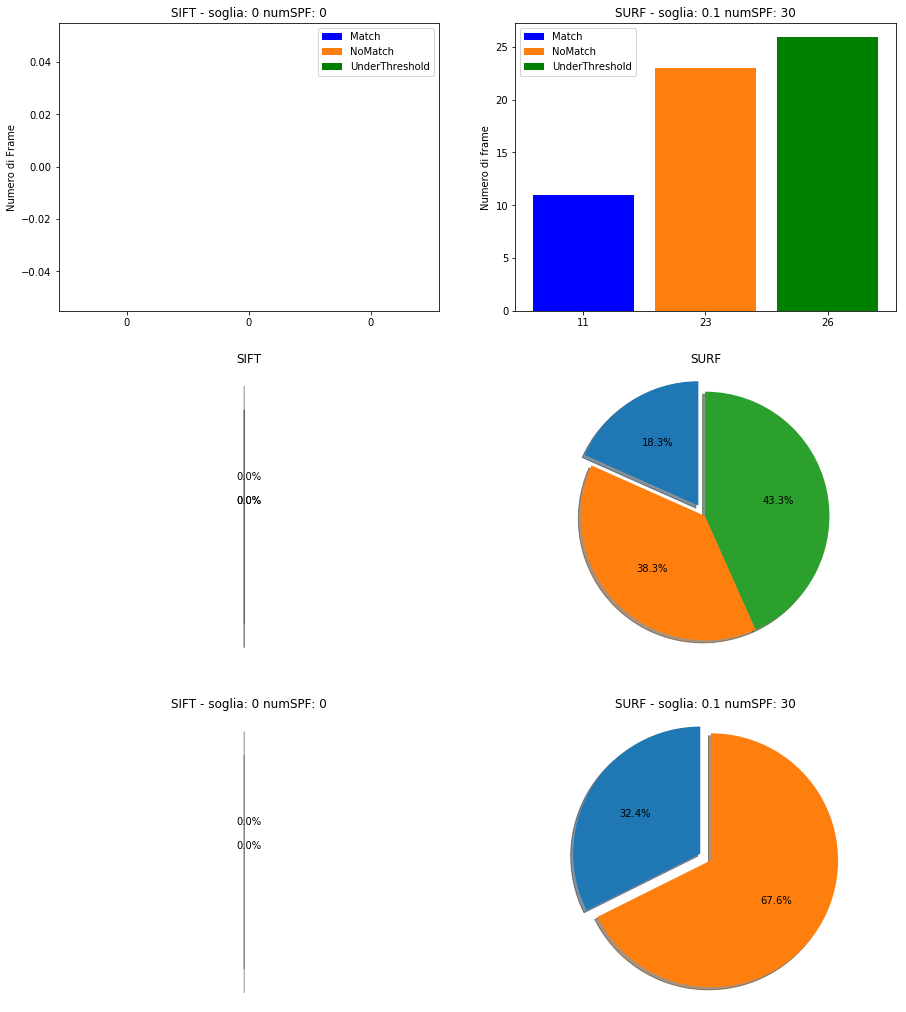

In [278]:
plotResult([], output,"prova_surf_luminoso.png", 0, 0.1,0 ,30, True)

In [259]:
for i in range(30, len(img_originali)):
    print "------FRAME ORIGINALE : ",i, "--------"
    for j in range(30, len(img_analisi)):
        matches = carImg(i,j)
        if matches is not None :
            dist = []
            for y in range(0, len(matches)):
                dist.append(matches[y].distance)
            dist = np.array(dist)
            if len(dist[dist< 0.1])>0:
                print "\t compare : ", j
                print "\t",np.max(dist), np.min(dist)
                print "\t", len(dist[dist< 0.1])


------FRAME ORIGINALE :  30 --------
	 compare :  30
	0.680789113045 0.022533159703
	160
	 compare :  31
	0.837424755096 0.0852131992579
	4
	 compare :  39
	0.787187039852 0.0774963721633
	1
	 compare :  40
	0.810080766678 0.0841347798705
	1


KeyboardInterrupt: 

In [214]:
img_originali = caricaImmagini("VideoOriginale\GotTrailerOriginal.mp4", 1)
img_analisi = caricaImmagini("VideoOriginale\Originale.mp4", 1)

In [217]:

for i in range(0, len(img_originali)):
    print "------FRAME ORIGINALE : ",i, "--------"
    for j in range(0, len(img_analisi)):
        matches = carImg(i,j)
        if matches is not None :
            dist = []
            for y in range(0, len(matches)):
                dist.append(matches[y].distance)
            dist = np.array(dist)
            if len(dist[dist< 0.1])>0:
                print "\t compare : ", j
                print "\t",np.max(dist), np.min(dist)
                print "\t", len(dist[dist< 0.1])


------FRAME ORIGINALE :  0 --------
	 compare :  31
	0.749298870564 0.0867971405387
	1
	 compare :  32
	0.741025447845 0.0713916644454
	1


KeyboardInterrupt: 

In [194]:

print matches[0].distance
# for i in range(0, len(matches)):
#     print matches[i].distance

 0.704986870289


0.704986870289 0.468596488237
0


In [182]:

for i in range(0, len(matches)):
    print matches[i].distance*100

44.7166204453
45.7797288895
63.0989015102
65.8990561962
47.9734420776
44.9532359838
42.6513940096
62.4336659908
68.7117874622
63.9422357082
67.1110630035
63.0186736584
58.0345988274
67.8690493107
47.7400302887
48.6087709665
48.1464058161
53.6081314087
37.285605073
44.8071867228
53.4733653069
40.7598137856
49.944075942
35.646045208
39.5048052073
55.6317269802
47.3021119833
30.7967543602
44.3799644709
59.2055499554
39.3393397331
48.0541169643
52.3083508015
39.0004187822
37.8410458565
62.2875988483
43.0593341589
43.2305425406
45.6482380629
60.9196424484
45.5026894808
23.636803031
29.2627334595
49.2847323418
24.5967581868
20.0025334954
64.1701221466
59.8471581936
16.7461946607
32.7447861433
20.3698948026
69.5834577084
43.9370274544
43.2830393314
64.9509012699
34.3026638031
38.1283044815
36.5049004555
55.1676869392
30.1177829504
30.441147089
57.1751534939
33.2678347826
46.9932049513
19.7518378496
41.3702785969
32.8480869532
45.4848438501
18.9336135983
43.3507859707
31.9372087717
24.98928159

In [137]:
distance = []
x = desc1[1][0]
f1 = np.sign(x)*((np.log(1+ m*(abs(x))))/(np.log(1+m)))
print f1
for i in range(0, len(desc1[1])):
    x = desc1[1][i]
    #for j in range(0, len(desc2[1])):
    
    y = desc2[1][0]
#         l2_norm1 = np.sqrt(sum(x**2))
#         l2_norm2 = np.sqrt(sum(y**2))
#         print l2_norm1, l2_norm2
#         print np.exp(2)
    m = 255
    f1 = np.sign(x)*((np.log(1+ m*(abs(x))))/(np.log(1+m)))
    f2 = np.sign(y)*((np.log(1+m*(abs(y))))/(np.log(1+m)))


#     f_1 = (f1/2)*10000
#     f_2 = (f2/2)*10000
    distance.append(np.sqrt(sum(f1 - f2)**2))
dist = np.array(distance)


[ -9.22669284e-03   2.12526638e-02   5.55100210e-04   7.17835501e-02
  -3.58002074e-02   4.84055690e-02  -1.48608238e-02   2.99943648e-02
  -1.07395649e-02   1.44661488e-02   4.58587140e-01   4.77180898e-01
  -4.19710368e-01   4.20358956e-01  -1.11875780e-01   1.19864881e-01
  -3.83029819e-01   3.88999701e-01   2.29932547e-01   2.29932547e-01
  -2.33525723e-01   2.33525723e-01   3.53588223e-01   3.53588223e-01
   1.19159043e-01   1.71398103e-01  -2.02711187e-02   3.22536938e-02
   6.81540146e-02   7.27335662e-02   7.94858336e-02   9.38445181e-02
  -1.32263172e-02   2.52301544e-01  -8.60968381e-02   1.69922367e-01
   2.13282689e-01   2.69239336e-01   2.64558256e-01   3.02831292e-01
   7.84086466e-01   7.99951077e-01   1.28002360e-01   2.53529221e-01
   6.53584778e-01   6.56547308e-01   3.47792268e-01   3.60372275e-01
  -6.98797345e-01   6.99083328e-01   7.01245427e-01   7.02784359e-01
  -6.71506107e-01   6.84666097e-01   7.12807298e-01   7.19913006e-01
  -3.23139042e-01   3.63045275e-01

In [136]:
print np.max(dist), np.min(dist)
print len(dist[dist<10])
print dist

16.2569903501 0.0073501849547
1033
[ 4.40943754  3.63734656  3.04647247 ...,  1.40954192  1.61390062
  2.03277285]


In [116]:
print np.max(dist), np.min(dist)
print len(dist[dist<0.0001])

140924.453735 0.0
16


In [94]:
# a = np.array(desc1[0][0])
# a_min = abs(np.min(a))

# print a_min
# print a
# a = a+a_min
# print a 
# a_max = abs(np.max(a))
# a_min = abs(np.min(a))
# b = [255*((val-a_min)/(a_max-a_min)) for val in a]
# print b

In [95]:
diff = []
for i in range(0, len(desc1[1])):
    for j in range(0, len(desc2[1])):
        diff.append((sum(np.sqrt((desc1[1][i]- desc2[1][j])**2))))
        
diff = np.array(diff)
print np.max(diff), np.min(diff)
s = 1
print diff[diff <s]
print len(diff[diff<s])

9.3051997062 1.35978899113
[]
0


ValueError: Invalid norm order for vectors.

In [23]:
# out2 = checkMatchRectangle([out1], 10)
# print out2

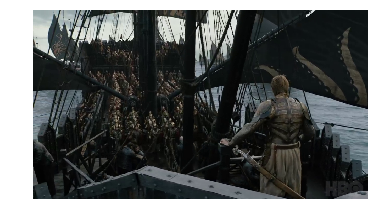

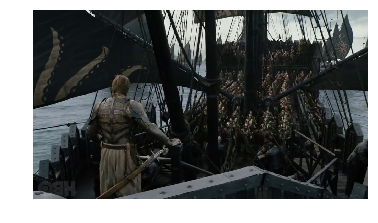

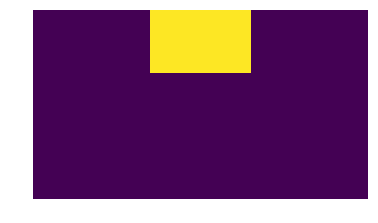

In [25]:
stampaImmagine(img1)
stampaImmagine(img2)
stampaImmagine(mask_0) # prova mask


In [27]:
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT AND MASK
kp1, des1 = sift.detectAndCompute(img1,mask_1)
kp2, des2 = sift.detectAndCompute(img2,mask_1)

print "Numero descrittori img 1: ", len(des1)
print  "DImensione descrittore 1",len(des1[0])
print des1[0]
print "Numero descrittori img 2: ", len(des2)

#Lavorare con i Keypoint
 # .pt prende le coordinate
    
print "COORDINATE PRIMO KP",kp1[0].pt

Numero descrittori img 1:  790
DImensione descrittore 1 128
[  13.    1.    3.   71.   24.    6.   16.   44.   76.    7.    3.    3.
    0.    0.   18.  111.   14.    6.    9.   15.    1.    3.   99.   75.
   14.    2.   25.   77.    9.    5.   18.   40.    2.    0.    0.    3.
    8.   29.  111.   75.   38.   30.   20.    5.   22.   16.   30.   68.
   57.   41.   38.   22.    4.    3.   22.   42.    9.    2.    7.   38.
   15.   39.  111.   31.    1.    0.    0.    0.   41.   74.   91.   62.
   11.    5.    4.    5.  111.   71.   10.    4.  111.   74.   54.    7.
    4.    2.    6.   29.   22.   34.  111.  105.    2.   11.   33.   22.
    1.    0.    6.   81.   96.   32.   20.   47.    0.    1.    6.   91.
  111.   18.    0.    0.    2.   17.   63.   82.   12.    0.    0.    0.
    0.    5.  106.   93.    1.    0.    0.    0.]
Numero descrittori img 2:  801
COORDINATE PRIMO KP (487.9908752441406, 240.04238891601562)


In [28]:
#MATCHING MANUALE
# matches = []
# for i in range (0, len (des1)):
#     temp = []
#     for j in range (0, len(des2)):
#         temp.append(np.sqrt(sum((des1[i] - des2[j])**2)))
#     temp = np.array (temp)
#     temp2 = []
#     temp2.append(np.min(temp))
#     temp = np.delete(temp, np.argmin(temp))
#     temp2.append(np.min(temp))
#     matches.append(temp2)
# print matches

In [29]:
# matches = []

# for i in range (0, len (des1)):
#     temp = []
#     for j in range (0, len(des2)):
#         temp.append(np.sqrt(sum((des1[i] - des2[j])**2)))
#     temp = np.array (temp)
#     temp2 = []
    
#     temp2.append([np.min(temp),i,np.argmin(temp)])
#     #temp = np.delete(temp, np.argmin(temp))
#     temp[np.argmin(temp)] = temp[np.argmin(temp)] + np.max(temp)
#     temp2.append([np.min(temp),i, np.argmin(temp)])
#     matches.append(temp2)
# print matches

In [30]:
matches = manualMatching(des1, des2)

KeyboardInterrupt: 

In [ ]:
out= filterLowe2(matches)
print len(out), out[0]
###### THRESHOLD  su out[0][0]

In [ ]:
#MATCHING PROVA
# matcher=cv2.BFMatcher()

#prendiamo i migliori 2 match
# matches=matcher.knnMatch(des1,des2,k=2)

# print matches[0][0].distance
# print matches[0][1].distance

In [ ]:
#se i due migliori match (2 punti per match)  hanno descrittori simili (distanza) 
# 80% li consideriamo uguali e li scartiamo 
# teniamo i match molto distanti tra loro < 80%
# def filterLowe(matches,threshold=0.8):
#     out_matches=[]
#     for m1,m2 in matches:
#         if m1.distance/m2.distance<threshold:
#             out_matches.append(m1)
#             return out_matches 

In [ ]:
# print len(matches)
# matches2=filterLowe(matches)
# print len(matches2)
# print "QUERY IDX", matches2[0].queryIdx

# ############### SU questi match applicare la threshold tra SIFT se  supera è un reale MATCH. 
# # MA NECESSITIAMO DI PIù MATCH per dire che un frame è uguale.
# print  "Distanza", matches2[0].distance

# des1[12]
# kp1[12].pt


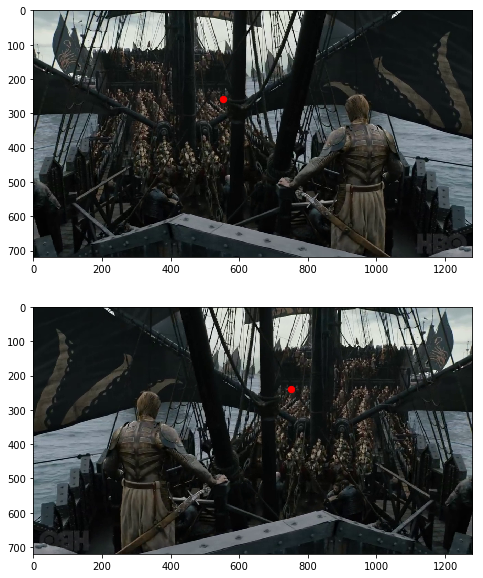

In [32]:


x = kp1[12].pt[0]
y = kp1[12].pt[1]

plt.figure(figsize=(16,10))
plt.subplot(211)
plt.imshow(img1)
plt.scatter(x,y,c='r', s=40)
plt.subplot(212)
plt.imshow(img2)
plt.scatter(kp2[0].pt[0],kp2[0].pt[1],c='r', s=40)

plt.show()

In [ ]:
# #MATCHING
# # create BFMatcher object
# bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# # Match descriptors.
# matches = bf.match(des1,des2)
# print len(matches)

# # Sort them in the order of their distance.
# matches = sorted(matches, key = lambda x:x.distance)
# print matches[0]. distance
# ## se la distanza è sotto una certa soglia allora prendiamo il match, 
# #più è bassa la distanza più i descrittori sono simili

# # Draw first 10 matches.
# img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:10],None)

# plt.figure(figsize=(16,10))
# plt.imshow(img3),plt.show()

TypeError: queryDescriptors data type = 17 is not supported

In [6]:
fls  = open("Prov.txt", "w")
 
fls.write("prova linea\n")
fls.write("Another line")

 
fls.close() 